In [2]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import csv

import dataset
import datasplit
import model.models as models
import trainer
import utils

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [3]:
models_folder = '../../models_and_results/models'
model_name = '20201027_fxnet_mono_disc_best'
results_folder = '../../models_and_results/results'
results_subfolder = '20201027_fxnet_mono_disc'

all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_correct.npy')), allow_pickle=True)
best_train_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_correct.npy')), allow_pickle=True)
best_val_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_correct.npy')), allow_pickle=True)
best_test_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'fx_labels.npy')), allow_pickle=True)

train_set_size = best_train_results.shape[0]
val_set_size = best_val_results.shape[0]
test_set_size = best_test_results.shape[0]

In [4]:
best_test_results[0]

array(['92432', 'G81-63504-RBM-T5S5-20961', '9', '9'], dtype='<U26')

In [5]:
fx_labels

array(['808', 'BD2', 'BMF', 'DPL', 'DS1', 'FFC', 'MGS', 'OD1', 'RAT',
       'RBM', 'SD1', 'TS9', 'VTB'], dtype='<U3')

In [6]:
# CONFUSION MATRICES

# Find best performance epoch based on validation
# Extract results from training and test for that epoch
best_val = 100 * max(all_val_correct) / val_set_size
best_val_idx = np.argmax(all_val_correct)

print("Best Validation Accuracy: ",best_val, "at epoch ", best_val_idx)
print("Training Accuracy: ", 100 * all_train_correct[best_val_idx] / train_set_size)
print("Test Accuracy: ", 100 * all_test_correct[best_val_idx] / test_set_size)

# Confusion matrices for best validation epoch
# extract predictions and targets vectors
train_preds = best_train_results[:, 2]
train_targets = best_train_results[:, 3]
val_preds = best_val_results[:, 2]
val_targets = best_val_results[:, 3]
test_preds = best_test_results[:, 2]
test_targets = best_test_results[:, 3]

# calculate conf. matrix
train_cm = confusion_matrix(y_true=train_targets, y_pred=train_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])
val_cm = confusion_matrix(y_true=val_targets, y_pred=val_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])
test_cm = confusion_matrix(y_true=test_targets, y_pred=test_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])

Best Validation Accuracy:  86.89934243803744 at epoch  32
Training Accuracy:  88.6483205180089
Test Accuracy:  86.29760025899397


In [7]:
print(test_cm)

[[ 972    0    7    0    0    0    0    0    0    0   27 1452    0]
 [   0 2499    1    1    2    0    0    0    7    5    3    0    2]
 [   0    0 2453    0    0    0    0    0    0    0    0    0    0]
 [   0    0    3  402    0    1    4    0   95    4    0    0    0]
 [   0    3   16    0 2441    0    0    0    3    3    0    0    0]
 [   0    1    0    0    0  599    0    0    2    7    0    0    0]
 [   0    0    6    1    0    0 2455    3    4    1   58    0    0]
 [   0    0    0    0    0    0    3  135    0    0  345    0    0]
 [   0    0    8   17    0    0    0    0 2559    4    0    0    0]
 [   0    0    2    1    0    0    0    0    0 2507    0    0    0]
 [   0    0    9    0    1    0   19   88    4    2 2333    0    0]
 [1128    0    3    0    0    0    0    0    0    0   30 1360    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  610]]


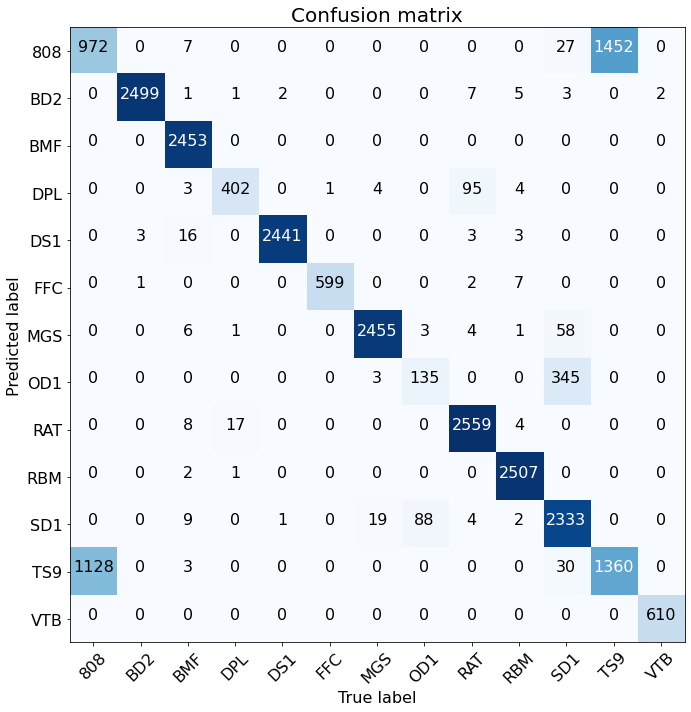

In [8]:
# Test CM
plt.figure(figsize=(10,10))

utils.plot_confusion_matrix(test_cm, fx_labels, normalize=False)

plt.xlabel('True label', fontsize=16)
plt.ylabel('Predicted label', fontsize=16)
# plt.title('FxNet - train = mono - test = mono', fontsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('font', size=16)


# plt.savefig('%s/%s/%s' % (results_folder, results_subfolder, 'fxnet_test_cm_norm.png'))

In [9]:
# extract vectors for dataframe
test_indexes = best_test_results[:, 0]
test_filenames = best_test_results[:, 1] 
test_preds = np.stack(best_test_results[:, 2])
test_targets = np.stack(best_test_results[:, 3])

test_df = pd.DataFrame(data={
                                'index': test_indexes, 
                                'filename': test_filenames,
                                'fx_pred': test_preds,
                                'fx_targ': test_targets 
                            })
test_df[:5]

,index,filename,fx_pred,fx_targ
0,92432,G81-63504-RBM-T5S5-20961,9,9
1,86461,G81-43103-RBM-T8S5-20908,9,9
2,117317,G71-46201-TS9-D5T0-20763,0,11
3,116732,G81-66411-TS9-D5T10-20955,11,11
4,27291,G71-58308-BMF-S8T0-20783,2,2


In [10]:
fx_labels

array(['808', 'BD2', 'BMF', 'DPL', 'DS1', 'FFC', 'MGS', 'OD1', 'RAT',
       'RBM', 'SD1', 'TS9', 'VTB'], dtype='<U3')

In [41]:
# select one effect to analyse - change fx label string accordingly
fx1 = test_df[test_df['filename'].str.contains('-DPL-')]
fx2 = test_df[test_df['filename'].str.contains('-RAT-')]

In [42]:
fx1.head()

,index,filename,fx_pred,fx_targ
7,37619,G81-62407-DPL-D10-20951,3,3
23,39361,G71-70511-DPL-D2-20812,3,3
78,38507,G61-56401-DPL-D8-20633,3,3
86,38187,G71-54304-DPL-D2-20779,3,3
136,38311,G83-50110-DPL-D10-20993,3,3


In [43]:
fx2.head()

,index,filename,fx_pred,fx_targ
10,71357,G63-65601-RAT-D5F8-20737,8,8
22,80488,G71-65601-RAT-D8F8-20815,8,8
26,75114,G63-51111-RAT-D8F8-20682,8,8
29,75455,G71-57307-RAT-D5F2-20782,8,8
33,80970,G91-59404-RAT-D8F2-21104,8,8


In [44]:
# select wrong predictions - change effect label number accordingly (e.g. 10 = SD1)
fx1_wrong_pred = fx1[fx1['fx_pred'].str.contains('8')]
fx2_wrong_pred = fx2[fx2['fx_pred'].str.contains('3')]

In [45]:
# print number of wrong predictions as a function of parameters
print('D10: ',  len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D10')]))
print('D8: ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D8')]))
print('D5: ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D5')]))
print('D2: ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D2')]))
print()
# print('D10 T10: ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D10T10-')]))
# print('D10 T8 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D10T8-')]))
# print('D10 T5 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D10T5-')]))
# print('D10 T2 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D10T2-')]))
# print('D10 T0 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D10T0-')]))
# print()
# print('D8 T10: ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D8T10-')]))
# print('D8 T8 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D8T8-')]))
# print('D8 T5 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D8T5-')]))
# print('D8 T2 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D8T2-')]))
# print('D8 T0 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D8T0-')]))
# print()
# print('D5 T10: ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D5T10-')]))
# print('D5 T8 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D5T8-')]))
# print('D5 T5 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D5T5-')]))
# print('D5 T2 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D5T2-')]))
# print('D5 T0 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D5T0-')]))
# print()
# print('D2 T10: ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D2T10-')]))
# print('D2 T8 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D2T8-')]))
# print('D2 T5 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D2T5-')]))
# print('D2 T2 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D2T2-')]))
# print('D2 T0 : ',   len(fx1_wrong_pred[fx1_wrong_pred['filename'].str.contains('-D2T0-')]))

D10:  68
D8:  15
D5:  11
D2:  1



In [48]:
# print number of wrong predictions as a function of parameters
print('D10: ',  len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D10')]))
print('D8: ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D8')]))
print('D5: ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D5')]))
print('D2: ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D2')]))
print()
print('D10 T10: ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D10F10-')]))
print('D10 T8 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D10F8-')]))
print('D10 T5 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D10F5-')]))
print('D10 T2 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D10F2-')]))
print('D10 T0 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D10F0-')]))
print()
print('D8 T10: ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D8F10-')]))
print('D8 T8 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D8F8-')]))
print('D8 T5 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D8F5-')]))
print('D8 T2 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D8F2-')]))
print('D8 T0 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D8F0-')]))
print()
print('D5 T10: ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D5F10-')]))
print('D5 T8 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D5F8-')]))
print('D5 T5 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D5F5-')]))
print('D5 T2 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D5F2-')]))
print('D5 T0 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D5F0-')]))
print()
print('D2 T10: ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D2F10-')]))
print('D2 T8 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D2F8-')]))
print('D2 T5 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D2F5-')]))
print('D2 T2 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D2F2-')]))
print('D2 T0 : ',   len(fx2_wrong_pred[fx2_wrong_pred['filename'].str.contains('-D2F0-')]))

D10:  1
D8:  1
D5:  10
D2:  5

D10 T10:  0
D10 T8 :  0
D10 T5 :  0
D10 T2 :  0
D10 T0 :  1

D8 T10:  0
D8 T8 :  0
D8 T5 :  0
D8 T2 :  0
D8 T0 :  1

D5 T10:  0
D5 T8 :  0
D5 T5 :  0
D5 T2 :  0
D5 T0 :  10

D2 T10:  1
D2 T8 :  1
D2 T5 :  0
D2 T2 :  1
D2 T0 :  2


In [59]:
# print wrong predictions where D = 5
print(wrong_df[wrong_df['filename'].str.contains('-D10-')])

       index                 filename fx_pred fx_targ
394    39414  G93-54304-DPL-D10-21169       8       3
1283   39758  G63-50300-DPL-D10-20697       8       3
1345   37907  G93-60405-DPL-D10-21183       8       3
2048   39302  G61-56306-DPL-D10-20625       8       3
2316   39205  G73-52207-DPL-D10-20847       8       3
2452   37809  G63-50205-DPL-D10-20689       8       3
2792   38775  G63-61406-DPL-D10-20716       8       3
3594   38816  G71-65410-DPL-D10-20798       8       3
4533   37482  G71-67508-DPL-D10-20809       8       3
4642   39649  G71-65506-DPL-D10-20807       8       3
4949   37609  G91-41101-DPL-D10-21062       8       3
5517   38537  G93-59309-DPL-D10-21174       8       3
5974   38811  G81-66602-DPL-D10-20972       8       3
6056   38905  G73-42102-DPL-D10-20829       8       3
6132   38468  G83-67508-DPL-D10-21043       8       3
6137   37923  G93-53303-DPL-D10-21168       8       3
6613   39082  G91-65601-DPL-D10-21127       8       3
6634   38543  G91-66411-DPL-

In [14]:
# print wrong predictions where D = 5
print(wrong_df[wrong_df['filename'].str.contains('-D2-')])

       index                filename fx_pred fx_targ
21203  39242  G63-51206-DPL-D2-20690       8       3


In [60]:
import shutil, os

in_folder_DPL = '/Volumes/STEVE/DATASETS/GUITAR-FX-DIST/DATA/Mono_Discrete/Audio/DPL'
in_folder_RAT = '/Volumes/STEVE/DATASETS/GUITAR-FX-DIST/DATA/Mono_Discrete/Audio/RAT'
out_folder_DPL = '/Users/Marco/Desktop/GFX_listening_test/DPL'
out_folder_RAT = '/Users/Marco/Desktop/GFX_listening_test/RAT'

wrong_df_sub = wrong_df[wrong_df['filename'].str.contains('-D10-')]
for filename in wrong_df_sub['filename']:
    shutil.copy('%s/%s%s' % (in_folder_DPL,filename,'.wav'), '%s/%s%s' % (out_folder_DPL,filename,'.wav'))

In [52]:
print(filename[:9]+'-SD1-'+'D2T0-'+filename[-5:])

G71-68509-SD1-D2T0-20810


In [33]:
filename = filename[14] = 'D'

TypeError: 'str' object does not support item assignment

In [30]:
filename[17]

'T'

In [62]:
wrong_df_sub = wrong_df[wrong_df['filename'].str.contains('-D10-')]
for filename in wrong_df_sub['filename']:
    filename = filename[:9]+'-RAT-'+'D2F0-'+filename[-5:]
    shutil.copy('%s/%s%s' % (in_folder_RAT,filename,'.wav'), '%s/%s%s' % (out_folder_RAT,filename,'.wav'))
    filename = filename[:9]+'-RAT-'+'D5F0-'+filename[-5:]
    shutil.copy('%s/%s%s' % (in_folder_RAT,filename,'.wav'), '%s/%s%s' % (out_folder_RAT,filename,'.wav'))
    filename = filename[:9]+'-RAT-'+'D8F0-'+filename[-5:]
    shutil.copy('%s/%s%s' % (in_folder_RAT,filename,'.wav'), '%s/%s%s' % (out_folder_RAT,filename,'.wav'))

In [12]:
# select one effect to analyse - change fx label string accordingly
df_808 = test_df[test_df['filename'].str.contains('-808-')]
df_ts9 = test_df[test_df['filename'].str.contains('-TS9-')]

In [21]:
# select wrong predictions - change effect label number accordingly (e.g. 10 = SD1)
wrong_df_808 = df_808[df_808['fx_pred'].str.match('11')]
wrong_df_ts9 = df_ts9[df_ts9['fx_pred'].str.match('0')]

In [24]:
wrong_df_808.shape

(1452, 4)

In [52]:
wrong_df_808_mod.shape

(1452, 4)

In [58]:
wrong_df_808_mod = wrong_df_808
wrong_df_808_mod['filename'] = wrong_df_808_mod['filename'].apply(lambda x: '%s%s%s' % (x[:14],'G',x[15:]))

<ipython-input-58-ce3e3fcbbaeb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_df_808_mod['filename'] = wrong_df_808_mod['filename'].apply(lambda x: '%s%s%s' % (x[:14],'G',x[15:]))


In [60]:
wrong_df_808_mod.head()

,index,filename,fx_pred,fx_targ
11,4831,G61-56211-808-G10T2-20617,11,0
34,4349,G71-47107-808-G10T0-20756,11,0
48,2520,G61-75611-808-G8T10-20669,11,0
107,3655,G93-64409-808-G2T0-21187,11,0
112,8350,G93-55305-808-G10T5-21170,11,0
